## Overview

This notebook develops some simple tools to identify sentiment in text. 

### Imports

In [6]:
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np

%matplotlib inline

### Helpers

In [7]:
analyzer = SentimentIntensityAnalyzer()

In [8]:
def is_username(text):
    if re.match("@[A-Za-z0-9_.]+",text):
        return True
    return False
    
def is_hashtag(text):
    if re.match("#[A-Za-z0-9_.]+",text):
        return True
    return False

## regular expression for finding unicode
myre = re.compile(u'['
    u'\U0001F300-\U0001F64F'
    u'\U0001F680-\U0001F6FF'
    u'\u2600-\u26FF\u2700-\u27BF]+', 
    re.UNICODE)

def strip_unicode(text):
    return myre.sub('',text)

def cleaned_text_for_langdect(word_list):
    new_text = ' '.join([word.lower() for word in word_list 
                         if not is_username(word) 
                         and not is_hashtag(word)])
    return strip_unicode(new_text)

### Data

In [9]:
df = pd.read_csv('loreal_comments.csv')

In [10]:
comment_dicts = list(df.T.to_dict().values())

In [11]:
enriched_comment_dicts = []
for comment_dict in comment_dicts:
    clean_text = cleaned_text_for_langdect(comment_dict['text'].split(" "))
    comment_dict['clean_text'] = clean_text
    comment_dict['text_blob_score'] = TextBlob(clean_text).sentiment.polarity
    comment_dict['vader_score'] = analyzer.polarity_scores(clean_text)['compound']
    enriched_comment_dicts.append(comment_dict)

In [12]:
sentiment_df = pd.DataFrame(enriched_comment_dicts)
cols = ['username','text','clean_text','text_blob_score','vader_score']
sentiment_df = sentiment_df[cols]

In [13]:
sentiment_df['compound_score'] = sentiment_df[['text_blob_score','vader_score']].mean(axis=1)

### Top 10 Positive Comments

In [14]:
top10_df = sentiment_df.sort_values(by=['compound_score'],ascending=False).head(10)

In [15]:
top10_df[['username','text','compound_score']]

,username,text,compound_score
175,aurelhhi,"The best With ""Greige Perfecto"" and ""Pink-a-po...",0.878950
198,lise_33,Awesome colour!,0.829400
149,timonel_m,Awesome 🤗,0.812450
115,kivanc.tatlitugfan,Perfect 💜,0.785950
139,angela.salomon1,Perfect for every day,0.785950
168,palvinxpictures,Barbbb 😍 It's perfect 💜,0.785950
52,ambre_dmh,Perfect 🌹,0.785950
13,clsmemories,No way. This color is perfect!!!😍😍,0.761450
81,_aysha_maryam,@lorealmakeup so beautiful,0.743050
85,blondiept,Love that shade!! Gonna have to buy one💄,0.740025


### Top 10 Negative Comments

In [16]:
bottom10_df = sentiment_df[sentiment_df.compound_score < 0].sort_values(by=['compound_score'],ascending=True).head(10)

In [17]:
bottom10_df[['username','text','compound_score']]

,username,text,compound_score
74,carolynegracebeauty,Desperately need this in America!!,-0.71435
71,siomarita.mx,Sería raro si se hiciera un tratamiento de ort...,-0.14800
206,cheryl_girlsaloud,I wil loreal makeup but its too much money 😢 (...,-0.12500


In [25]:
bottom10_df.loc[206].text

'I wil loreal makeup but its too much money 😢 (sorry my english is bad)'

### Sentiment Distribution

In [18]:
n = sentiment_df.shape[0]
pos_count = sentiment_df[sentiment_df.compound_score > 0].shape[0]
neg_count = sentiment_df[sentiment_df.compound_score < 0].shape[0]
neu_count = sentiment_df[sentiment_df.compound_score == 0].shape[0]

In [28]:
m = pos_count + neg_count
np.array([pos_count,neg_count])/m

array([ 0.9625,  0.0375])

In [19]:
sent_dist = np.array([pos_count,neu_count,neg_count])/n

In [26]:
sent_dist

array([ 0.36492891,  0.62085308,  0.01421801])

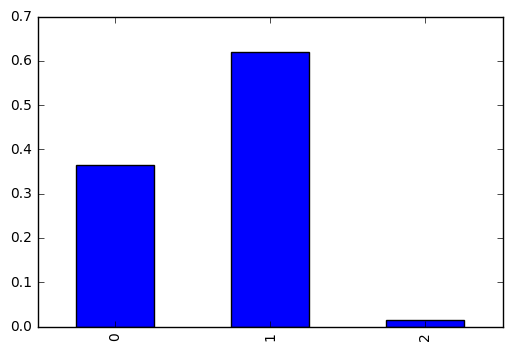

In [20]:
## this is very clearly wrong. not capturing emojis whatsoever!!!!
pd.Series(sent_dist).plot(kind='bar')